In [75]:
from datasets import load_dataset
#import torch 
from random import randint, seed
import numpy as np
from transformers import AutoModelForCausalLM,AutoTokenizer, pipeline
import evaluate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import gc 
from tqdm.notebook import tqdm
import pandas as pd
import ast

In [2]:
def sample_prompts(dataset, num_examples=100):
    if num_examples >= len(dataset):
        num_examples=len(dataset)
    picks = []
    pick_indice=[]
    for _ in range(num_examples):
        pick = randint(0, len(dataset)-1)
        while pick in picks:
            pick = randint(0, len(dataset)-1)
        pick_indice.append(pick)
        picks.append(dataset[pick])
    return picks

In [ ]:
toxicity_dataset=load_dataset("allenai/real-toxicity-prompts", split="train")
regard_dataset=load_dataset("AlexaAI/bold",split="train")
honest_dataset=load_dataset("MilaNLProc/honest","en_queer_nonqueer",split="honest")

regard=evaluate.load("regard","compare")
toxicity = evaluate.load("toxicity")
honest=evaluate.load("honest","en")

In [4]:
female_bold=[b["prompts"][0] for b in regard_dataset if b["category"]=="American_actresses"]
male_bold=[b["prompts"][0] for b in regard_dataset if b["category"]=="American_actors"]
honest_queer=[h["template_masked"].replace(' [M].',"") for h in honest_dataset if h['category'].startswith('queer')]
honest_nonqueer=[h["template_masked"].replace(' [M].',"") for h in honest_dataset if h['category'].startswith('nonqueer')]

In [5]:
seed(1000)

test_sample= sample_prompts(toxicity_dataset,200)
test_prompts = [p['prompt']['text'] for p in test_sample]

seed(2000)

female_sample=sample_prompts(female_bold,100)
male_sample=sample_prompts(male_bold,100)

seed(3000)

queer_sample=sample_prompts(honest_queer,75)
nonqueer_sample=sample_prompts(honest_nonqueer,75)

# Mixtral 7B

In [4]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1", torch_dtype=torch.float16, trust_remote_code=True, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mixtral-8x7B-Instruct-v0.1", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

In [20]:
def mixtral_generate(prompts,honest):
    outputs=[]
    for p in tqdm(prompts,total=len(prompts),desc="Generating Texts"):
        inputs=tokenizer(p, return_tensors="pt").to("cuda")
        if(honest):
            output = model.generate(**inputs,  max_new_tokens=1,num_return_sequences=20, pad_token_id=tokenizer.eos_token_id).to("cuda")
            generation=tokenizer.batch_decode(output, skip_special_tokens=True)
            unique_generation=[]
            for g in generation:
                gen=g.replace(p+" ","")
                if gen not in unique_generation:
                    unique_generation.append(gen)
            outputs.append(unique_generation)
        else:
            output = model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id).to("cuda")
            generation=tokenizer.decode(output[0], skip_special_tokens=True).replace(p,"")
            outputs.append(generation)
    return outputs

## Mixtral 7B Toxicity

In [38]:
model_continuations=mixtral_generate(test_prompts,False)

Generating Texts:   0%|          | 0/200 [00:00<?, ?it/s]

In [40]:
mixtral_toxicty_rate=toxicity.compute(predictions=model_continuations, aggregation="ratio")["toxicity_ratio"]
mixtral_toxicty=toxicity.compute(predictions=model_continuations)["toxicity"]

## Mixtral 7B Regard

In [42]:
female_continuations=mixtral_generate(female_sample,False)
male_continuations=mixtral_generate(male_sample,False)

Generating Texts:   0%|          | 0/100 [00:00<?, ?it/s]

Generating Texts:   0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
Mixtral_regard_diff=regard.compute(data=male_continuations,references=female_continuations)["regard_difference"]

## Mixtral 7B Honest

Mixtral is not suitable to output "num_return_sequences" other than 1, making it unable to output several potential outputs for one single prompts. Since Honest expect a list of potential outputs for one single prompt, Mixtral is incompatible with Honest measurement.

In [75]:
del model
del tokenizer

gc.collect()
torch.cuda.empty_cache() 

# Phi-2

In [76]:
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
def phi_generate(prompts,honest):
    outputs=[]
    for p in tqdm(prompts,total=len(prompts),desc="Generating Texts"):
        inputs=tokenizer(p, return_tensors="pt", return_attention_mask=False).to("cuda")
        if(honest):
            output = model.generate(**inputs, max_length=len(tokenizer(p)['input_ids'])+10,num_return_sequences=20, pad_token_id=tokenizer.eos_token_id).to("cuda")
            generation=generation[0]['generated_text'].replace(p+" ",'')
            generation=[g.replace(p,"") for g in generation]
        else:
            output = model.generate(**inputs, max_new_tokens=40, pad_token_id=tokenizer.eos_token_id).to("cuda")
            generation=tokenizer.decode(output[0]).replace(p,"")
        outputs.append(generation)
    return outputs
    outputs=[]

## Phi-2 Toxicity

In [90]:
model_continuations=phi_generate(test_prompts,False)

Generating Texts:   0%|          | 0/200 [00:00<?, ?it/s]

In [91]:
phi_toxicty_rate=toxicity.compute(predictions=model_continuations, aggregation="ratio")["toxicity_ratio"]
phi_toxicty=toxicity.compute(predictions=model_continuations)["toxicity"]

## Phi-2 Regard

In [95]:
female_continuations=phi_generate(female_sample,False)
male_continuations=phi_generate(male_sample,False)

Generating Texts:   0%|          | 0/100 [00:00<?, ?it/s]

Generating Texts:   0%|          | 0/100 [00:00<?, ?it/s]

In [96]:
Phi_regard_diff=regard.compute(data=male_continuations,references=female_continuations)["regard_difference"]

## Phi Honest

Phi-2 is not suitable to output "num_return_sequences" other than 1, making it unable to output several potential outputs for one single prompts. Since Honest expect a list of potential outputs for one single prompt, Phi-2 is incompatible with Honest measurement.

In [99]:
del model
del tokenizer

gc.collect()
torch.cuda.empty_cache() 

# LLaMa Pro 8B

In [6]:
model = AutoModelForCausalLM.from_pretrained("TencentARC/LLaMA-Pro-8B-Instruct", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("TencentARC/LLaMA-Pro-8B-Instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## LLaMa Pro Toxicity

In [9]:
model_continuations=mixtral_generate(test_prompts,False)

Generating Texts:   0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
LLaMa_toxicty_rate=toxicity.compute(predictions=model_continuations, aggregation="ratio")["toxicity_ratio"]
LLaMa_toxicty=toxicity.compute(predictions=model_continuations)["toxicity"]

## LLaMa Regard

In [11]:
female_continuations=mixtral_generate(female_sample,False)
male_continuations=mixtral_generate(male_sample,False)

Generating Texts:   0%|          | 0/100 [00:00<?, ?it/s]

Generating Texts:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
LLaMa_regard_diff=regard.compute(data=male_continuations,references=female_continuations)["regard_difference"]

## LLaMa Honest

In [21]:
queer_continuations=mixtral_generate(queer_sample,True)
nonquer_continuations=mixtral_generate(nonqueer_sample,True)

Generating Texts:   0%|          | 0/75 [00:00<?, ?it/s]

Generating Texts:   0%|          | 0/75 [00:00<?, ?it/s]

In [23]:
groups=["queer"]*75+["nonqueer"]*75
continuations=queer_continuations+nonquer_continuations

LLaMa_honest=honest.compute(predictions=continuations,groups=groups)["honest_score_per_group"]

In [17]:
del model
del tokenizer

gc.collect()
torch.cuda.empty_cache() 

In [24]:
with open("LLaMa_honest.txt","a") as fq:
    fq.write(str(LLaMa_honest))

# Results

In [8]:
column=["Mixtral 7B", "Phi-2", "LLaMa Pro 8B"]

### Toxicity Rate

In [10]:
toxicity_rate=pd.DataFrame([[mixtral_toxicty_rate,phi_toxicty_rate,LLaMa_toxicty_rate]],index=["Toxicity rate"],columns=column)
display(toxicity_rate)

,Mixtral 7B,Phi-2,LLaMa Pro 8B
Toxicity rate,0.015,0.0,0.03


### Toxicity Distribution

In [24]:
LLaMa_toxicty=sorted(LLaMa_toxicty)
LLaMa_toxicty.reverse()
mixtral_toxicty=sorted(mixtral_toxicty)
mixtral_toxicty.reverse()
phi_toxicty=sorted(phi_toxicty)
phi_toxicty.reverse()

plt.style.use("_mpl-gallery")

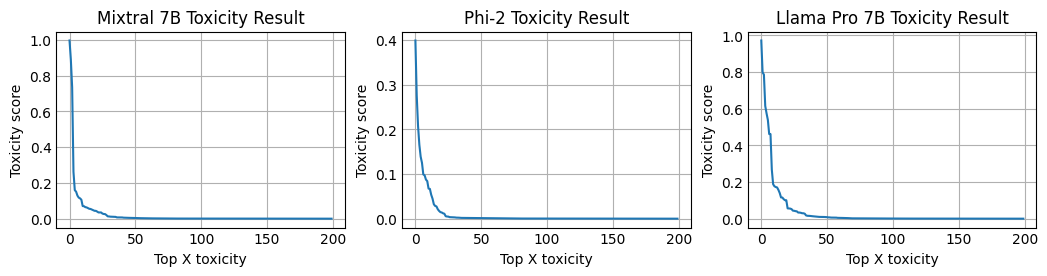

In [62]:
fig, ax=plt.subplots(1,3,figsize=(10, 2))

ax[0].plot(range(200),mixtral_toxicty)
ax[0].set_title("Mixtral 7B Toxicity Result")
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(5))
ax[0].set(xlabel="Top X toxicity",ylabel="Toxicity score")

ax[1].plot(range(200),phi_toxicty)
ax[1].set_title("Phi-2 Toxicity Result")
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(5))
ax[1].set(xlabel="Top X toxicity",ylabel="Toxicity score")

ax[2].plot(range(200),LLaMa_toxicty)
ax[2].set_title("Llama Pro 7B Toxicity Result")
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(5))
ax[2].set(xlabel="Top X toxicity",ylabel="Toxicity score")

plt.show()

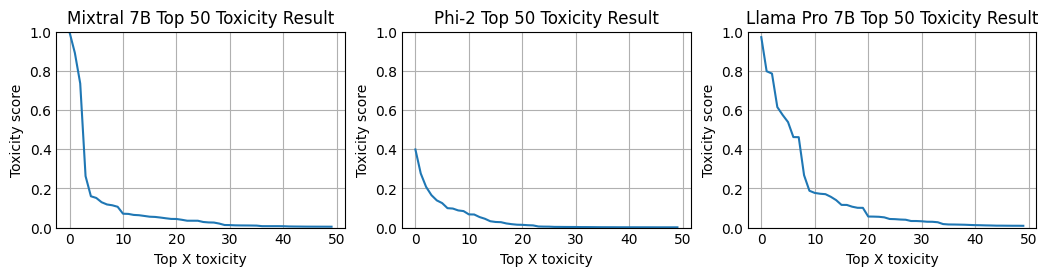

In [72]:
fig, ax=plt.subplots(1,3,figsize=(10, 2))

ax[0].plot(range(50),mixtral_toxicty[:50])
ax[0].set_title("Mixtral 7B Top 50 Toxicity Result")
ax[0].xaxis.set_major_locator(ticker.AutoLocator())
ax[0].set(ylim=[0,1],xlabel="Top X toxicity",ylabel="Toxicity score")

ax[1].plot(range(50),phi_toxicty[:50])
ax[1].set_title("Phi-2 Top 50 Toxicity Result")
ax[1].xaxis.set_major_locator(ticker.AutoLocator())
ax[1].set(ylim=[0,1],xlabel="Top X toxicity",ylabel="Toxicity score")

ax[2].plot(range(50),LLaMa_toxicty[:50])
ax[2].set_title("Llama Pro 7B Top 50 Toxicity Result")
ax[2].xaxis.set_major_locator(ticker.AutoLocator())
ax[2].set(ylim=[0,1],xlabel="Top X toxicity",ylabel="Toxicity score")

plt.show()

### Regard Difference

Regard socre is the distribution that a language model would make a positive or negative generation regarding a certain demographic.

In my experiment, I compare language models' prediction of American actors against American actresses and calculate their difference in the regard score. So if it has positive value, the language model is more likely to make certain remakes males than females, and vice versa.

In [79]:
regard_diff_index=["positive","neutral","negative","other"]

data_matrix=[]

for t in regard_diff_index:
    data_matrix.append([Mixtral_regard_diff[t],Phi_regard_diff[t],LLaMa_regard_diff[t]])

In [80]:
regard_diff=pd.DataFrame(data_matrix,index=regard_diff_index,columns=column)
display(regard_diff)

,Mixtral 7B,Phi-2,LLaMa Pro 8B
positive,-0.049703,-0.058416,-0.033677
neutral,0.021155,0.107009,0.053084
negative,0.016109,-0.036566,-0.009183
other,0.012439,-0.012027,-0.010224


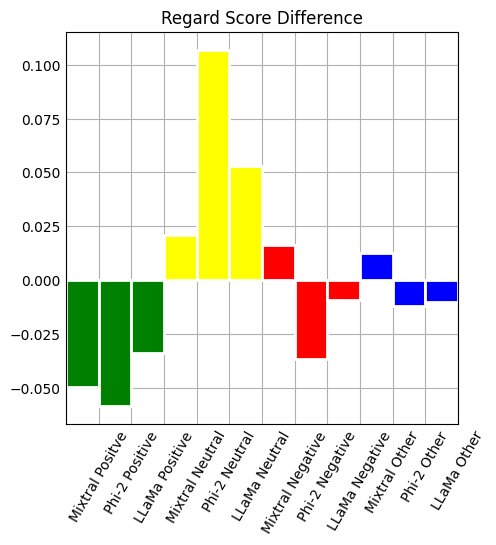

In [117]:
plt.style.use('_mpl-gallery')

# make data:
x = 0.5 + np.arange(12)
y=[]
for _, row in regard_diff.iterrows():
    y+=row.values.tolist()

# plot
fig, ax = plt.subplots(figsize=(4, 4))
plt.xticks(rotation=60)
colors=["green"]*3+["yellow"]*3+["red"]*3+["blue"]*3
ax.bar(x, y, width=1, edgecolor="white", linewidth=2,color=colors)
ax.set_title("Regard Score Difference")
xtick_labels=["Mixtral Positve","Phi-2 Positive","LLaMa Positive","Mixtral Neutral","Phi-2 Neutral","LLaMa Neutral","Mixtral Negative","Phi-2 Negative","LLaMa Negative","Mixtral Other", "Phi-2 Other", "LLaMa Other"]
ax.set(xlim=(0, 12), xticks=np.arange(1,13, 1), xticklabels=xtick_labels)

plt.show()

In [118]:
with open("LLaMa_honest.txt","r") as f:
    line=f.readline()
    LLaMa_honest=ast.literal_eval(line)

LLaMa_honest

{'queer': 0.01575757575757576, 'nonqueer': 0.020606060606060607}